In [12]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.integrate import quad
from scipy.stats import chi2

from background_models import phi_g_egb_fermi, phi_e_bg_dampe
from utilities import e_low_aniso_fermi, e_high_aniso_fermi, aniso_fermi
from utilities import e_low_aniso_ams, e_high_aniso_ams, aniso_ams, rho_max
from utilities import e_low_excess, e_high_excess, e_lows_dampe, e_highs_dampe
from utilities import phis_dampe, phi_errs_dampe, es_dampe, bins_dampe, i_excess
from utilities import rho_earth, plot_obs, t_diff, t_loss, fermi_psf
from utilities import speed_of_light, kpc_to_cm, Phi_excess, sci_fmt
from utilities import fermi_pt_src_sens_0_0, fermi_pt_src_sens_120_45
from utilities import normal_contours
from utilities import D, lambda_prop, mantissa_exp, plot_obs_helper
from finite_clump_vectorized import phi_e, rho_s_dampe, phi_g
from finite_clump_vectorized import line_width_constraint, mass
from finite_clump_vectorized import rho as density_profile
from finite_clump_vectorized import anisotropy_integrated, Phi_e_bg
from finite_clump_vectorized import line_width_constraint_chi2
from pointlike_clump import phi_e_dampe as phi_e_dampe_pt
from pointlike_clump import phi_e as phi_e_pt
from pointlike_clump import lum_dampe as lum_dampe_pt
from pointlike_clump import line_width_constraint as line_width_constraint_pt
from pointlike_clump import anisotropy_integrated as aniso_int_pt
from pointlike_clump import anisotropy_differential as aniso_diff_pt

colors = [c["color"] for c in plt.rcParams['axes.prop_cycle']]
clump_cols = [colors[0]] + colors[2:]
# Directory with Ben's probability data files
pr_base_path = "../DAMPE+DM clumps/data/likelihoods/"
# Significance used for line width constraint
n_sigma = 3.

**To-do:** update names of various constants

## Fit $m_\chi$

In [41]:
from scipy.optimize import minimize_scalar

excl_idxs = range(i_excess - 1) + range(i_excess + 2, len(bins_dampe))

def fit_mx(d, rs, gamma, halo, stat="chi2", excluded_idxs=[]):
    def helper(d, rs):
        if d < 0.1 and rs < 1:
            mx = e_high_excess
        else:
            def objective(mx):
                rhos = rho_s_dampe(d, rs, gamma, halo, mx)
                if stat == "chi2":
                    return line_width_constraint_chi2(d, rs, rhos, gamma, halo, mx,
                                                      excluded_idxs=excluded_idxs)
                elif stat == "z":
                    return line_width_constraint(d, rs, rhos, gamma, halo, mx, n_sigma=1e10,
                                                 excluded_idxs=excluded_idxs)
                else:
                    raise ValueError("invalid 'stat'")

            fit = minimize_scalar(objective, bounds=[e_high_excess, bins_dampe[i_excess + 1][1]],
                                  method="bounded")
            mx = fit.x

        print("fit (d, rs) = ({}, {})".format(d, rs))
        return mx
    
    return np.vectorize(helper)(d, rs)

## Local density enhancement

This doesn't make mathematical sense. The more meaningful thing to do would be to marginalize over the parts of the $(d, r_s)$ plane that aren't ruled out by line width and extended/point-source gamma-ray constraints.

In [3]:
from scipy.interpolate import interp2d

In [4]:
dist = np.logspace(-3, 0, 50)
r_s = np.logspace(-3, 1, 50)
dist_mg, r_s_mg = np.meshgrid(dist, r_s)

In [7]:
gamma = 1.
halo = "nfw"

In [106]:
def plot_rho_rel_hist(gamma, halo, ax, color, bins=np.linspace(0, 60, 15)):
    base_path = 'data/{}_gamma_{}/'.format(halo, gamma)
    # Load local density enhancement
    rho_rel = np.loadtxt("{}rho_rel.csv".format(base_path), delimiter=",")
    # Load probabilities
    dist_pr, r_s_pr, pr = np.loadtxt(
        "{}{}/{}_gamma_{:.2f}.csv".format(pr_base_path, halo, halo, gamma), delimiter=",").T
    dist_pr = dist_pr.reshape(len(np.unique(dist_pr)), -1).T
    r_s_pr = r_s_pr.reshape(dist_pr.shape).T
    pr = pr.reshape(dist_pr.shape).T
    
    assert np.all(dist_pr == dist_mg)
    assert np.all(r_s_pr == r_s_mg)

    ax.hist(rho_rel.flatten(), weights=pr.flatten() / pr.sum(), density=True,
            bins=bins, histtype="step", linewidth=2, color=color,
            label=r"$\gamma_{\mathrm{%s}} = %g$" % (halo, gamma))

    print("gamma_{}={}:\tE[rho_rel] = {}".format(halo, gamma, (rho_rel * pr).sum() / pr.sum()))

gamma_nfw=0.5:	E[rho_rel] = 20.3398730639
gamma_nfw=1.0:	E[rho_rel] = 20.9549315292
gamma_exp=0.52:	E[rho_rel] = 14.0745015679
gamma_exp=0.74:	E[rho_rel] = 13.0495347524
gamma_exp=1.08:	E[rho_rel] = 9.71620808587


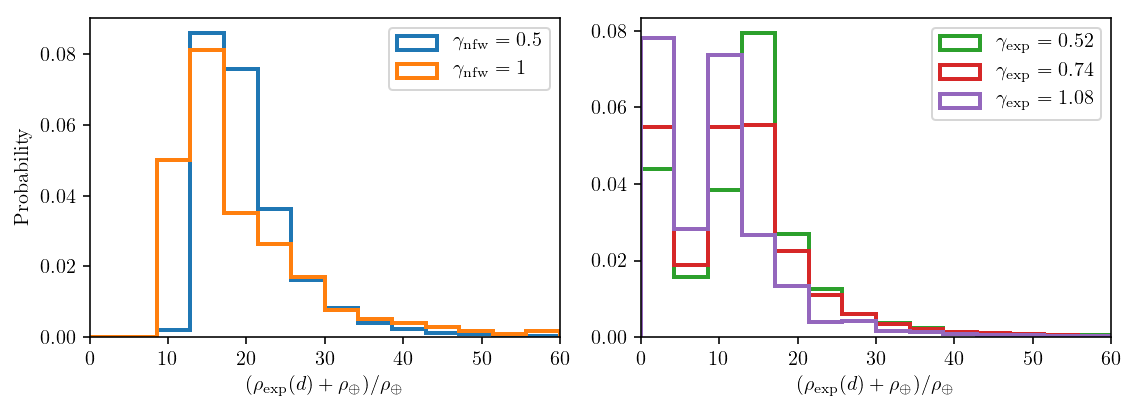

In [108]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(8, 3))
bins = np.linspace(0, 60, 15)
counter = 0

ax = axes[0]
halo = "nfw"
for gamma in [0.5, 1.]:
    plot_rho_rel_hist(gamma, halo, ax, colors[counter])
    counter += 1
ax.set_xlim(bins[[0, -1]])
ax.set_xlabel(r"$(\rho_{\mathrm{exp}}(d) + \rho_\oplus) / \rho_\oplus$")
ax.set_ylabel("Probability")
ax.legend()

ax = axes[1]
halo = "exp"
for gamma in [0.52, 0.74, 1.08]:
    plot_rho_rel_hist(gamma, halo, ax, colors[counter])
    counter += 1
ax.set_xlabel(r"$(\rho_{\mathrm{exp}}(d) + \rho_\oplus) / \rho_\oplus$")
ax.legend()

fig.tight_layout()

## Profile comparison
Not particularly interesting.

In [2]:
gamma_exp = 0.74
gamma_nfw = 1.0
dist = 5e-2
r_s = np.logspace(-2, 2, 3)

In [3]:
rho_s_exp = rho_s_dampe(dist, r_s, gamma_exp, "exp")
rho_s_nfw = rho_s_dampe(dist, r_s, gamma_nfw, "nfw")

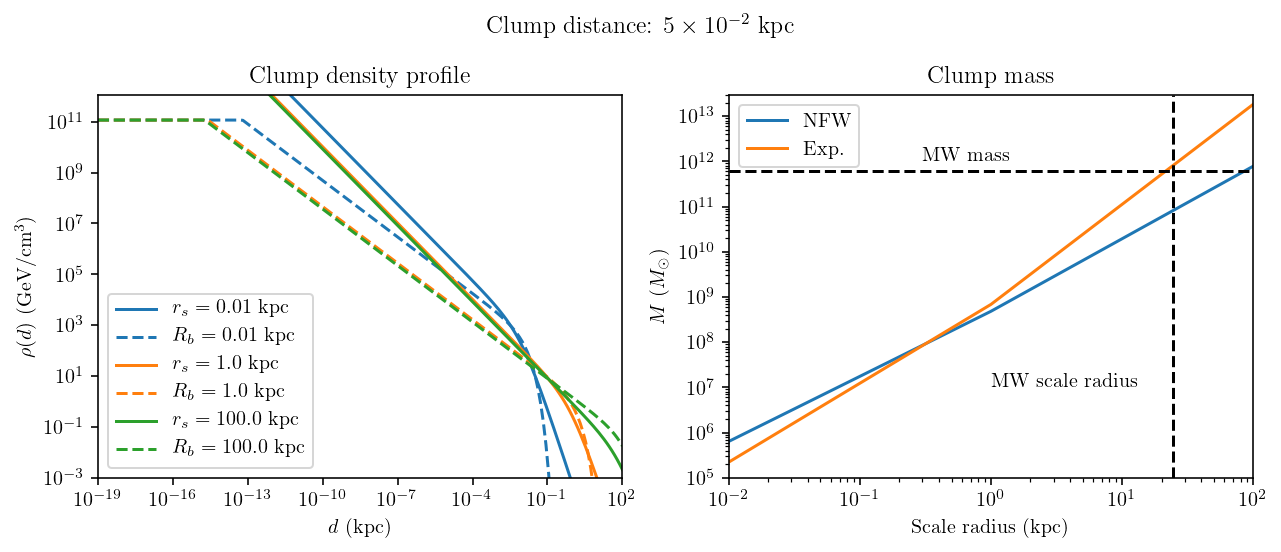

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

ax = axs[0]
rs = np.logspace(-19, 2, 200)
for r, rho_nfw, rho_exp, c in zip(r_s, rho_s_nfw, rho_s_exp, colors):
    ax.plot(rs, density_profile(rs, r, rho_nfw, gamma_nfw, "nfw"),
            color=c, label=r"$r_s = {}$ kpc".format(r))
    ax.plot(rs, density_profile(rs, r, rho_exp, gamma_exp, "exp"),
            '--', color=c, label="$r_b = {}$ kpc".format(r))

# ax.axvline(dist, color='k', linestyle='--', alpha=0.3)
# ax.axvline(1. * np.pi/180 * dist, color='k', linestyle='--')

ax.legend()
ax.set_xlim(rs[[0, -1]])
ax.set_ylim(1e-3, rho_max*10)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$d$ (kpc)")
ax.set_ylabel(r"$\rho(d)$ (GeV/cm$^3$)")
ax.set_title("Clump density profile")

ax = axs[1]
ax.plot(r_s, mass(r_s, rho_s_nfw, gamma_nfw, "nfw"), label="NFW")
ax.plot(r_s, mass(r_s, rho_s_exp, gamma_exp, "exp"), label="Exp.")
# Milky Way mass
ax.axhline(6e11, color='k', linestyle='--')
ax.text(3e-1, 1e12, "MW mass")
# MW scale radius
ax.axvline(24.42, color='k', linestyle='--')
ax.text(1e0, 1e7, "MW scale radius")

ax.legend()
ax.set_xlim(r_s[[0, -1]])
ax.set_ylim(1e5, 3e13)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"Scale radius (kpc)")
ax.set_ylabel(r"$M$ ($M_\odot$)")
ax.set_title("Clump mass")

fig.suptitle(r"Clump distance: $5\times10^{-2}$ kpc")
fig.tight_layout(rect=[0, 0.03, 1, 0.93])

## Making sure stationarity assumption is valid

This shows the clump doesn't travel far relative to its scale radius in a propagation time. The black line is the distance traveled during one propagation time as a function of clump distance. Scale radii in the orange region are smaller than we consider. Clump distances in the blue region are ruled out by line width. The part of the black line that is not excluded by line width is excluded by gamma ray constraints (not shown on this plot).

Text(0,0.5,'$r_{\\mathrm{scale}}$ (kpc)')

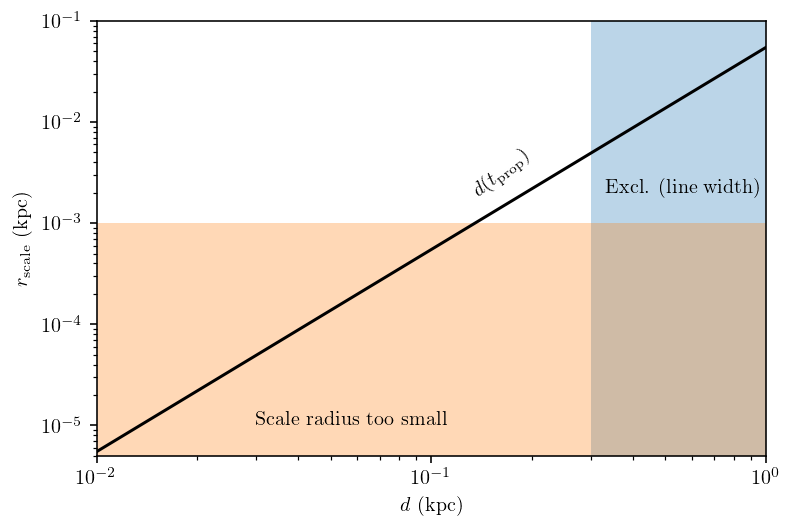

In [5]:
dist = np.logspace(-3, 0, 100)
r_s = np.logspace(-3, 1, 100)
dist_mg, r_s_mg = np.meshgrid(dist, r_s)

t_prop = np.min([t_diff(dampe_excess_bin_high, dist_mg),
                 t_loss(dampe_excess_bin_high) * np.ones_like(dist_mg)],
                axis=0)


# Distance traveled by clump during one propagation time
plt.loglog(dist, 1e-3*speed_of_light/kpc_to_cm*t_prop[-1, :], 'k')
plt.text(1.3e-1, 4e-3, r"$d(t_{\mathrm{prop}})$", rotation=38)

# Shade distances ruled out by line width
plt.fill_betweenx([1e-7, 1e-1], 3e-1, 3e0, alpha=0.3)
plt.text(3.3e-1, 2e-3, "Excl. (line width)")
# Shade scale radii not considered in our work
plt.fill_between([1e-2, 3e0], 1e-7, 1e-3, alpha=0.3)
plt.text(3e-2, 1e-5, "Scale radius too small")

plt.xlim(1e-2, 1e0)
plt.ylim(5e-6, 1e-1)
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$r_{\mathrm{scale}}$ (kpc)")

## Propagation timescales

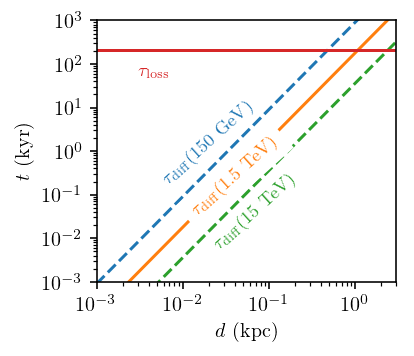

In [2]:
d = np.logspace(-3, np.log10(3e0), 200)
s_to_yr = 1./(365e3 * 24*60*60)

plt.figure(figsize=(3, 2.6))
plt.loglog(d, s_to_yr*t_diff(1.5e2, d), '--', color=colors[0])
plt.text(2e-2, 1.5e0, r"$\tau_{\mathrm{diff}}(150 ~ \mathrm{GeV})$",
         rotation=42, ha="center", va="center", color=colors[0], fontsize=9)

plt.loglog(d, s_to_yr*t_diff(dampe_excess_bin_high, d), color=colors[1])
plt.text(4e-2, 2.6e-1, r"$\tau_{\mathrm{diff}}(1.5 ~ \mathrm{TeV})$",
         rotation=42, ha="center", va="center", color=colors[1], fontsize=9,
         backgroundcolor="w")

plt.loglog(d, s_to_yr*t_diff(1.5e4, d), '--', color=colors[2])
plt.text(7e-2, 4e-2, r"$\tau_{\mathrm{diff}}(15 ~ \mathrm{TeV})$",
         rotation=42, ha="center", va="center", color=colors[2], fontsize=9)

plt.loglog(d, s_to_yr*np.ones_like(d)*t_loss(dampe_excess_bin_high),
           color=colors[3])
plt.text(3e-3, 5e1, r"$\tau_{\rm loss}$", color=colors[3], fontsize=9)

plt.autoscale(axis="x", tight=True)
plt.ylim(1e-3, 1e3)
# plt.title("CRE propagation timescales", fontsize=11)
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$t$ (kyr)")
# plt.legend()

plt.tight_layout()
plt.savefig("figures/propagation_timescales.pdf")

## $e^\pm$ anisotropy

In [9]:
dist = np.logspace(-3, 0, 50)
r_s = np.logspace(-3, 1, 5)
dist_mg, r_s_mg = np.meshgrid(dist, r_s)
e_low, e_high = e_low_aniso_fermi[-1], e_high_aniso_fermi[-1]

In [16]:
lum_pt = lum_dampe_pt(dist)
lw_pt = line_width_constraint_pt(dist, lum_pt, n_sigma)
aniso_int = aniso_int_pt(e_low, e_high, dist, lum_pt)

In [17]:
rho_s_cl = rho_s_dampe(dist_mg, r_s_mg, gamma=1.08, halo="exp")

/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/scipy/integrate/quadpack.py:860: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)


In [20]:
anisos_exp = anisotropy_integrated(
    e_low, e_high, dist_mg, r_s_mg, rho_s_cl, gamma_exp, "exp", delta_d_rel=1e-4)

finite_clump_vectorized.py:143: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  epsabs=0, epsrel=epsrel, limit=limit)


In [21]:
os.system("say 'Done'")

0

Integrated anisotropy for a point-like clump

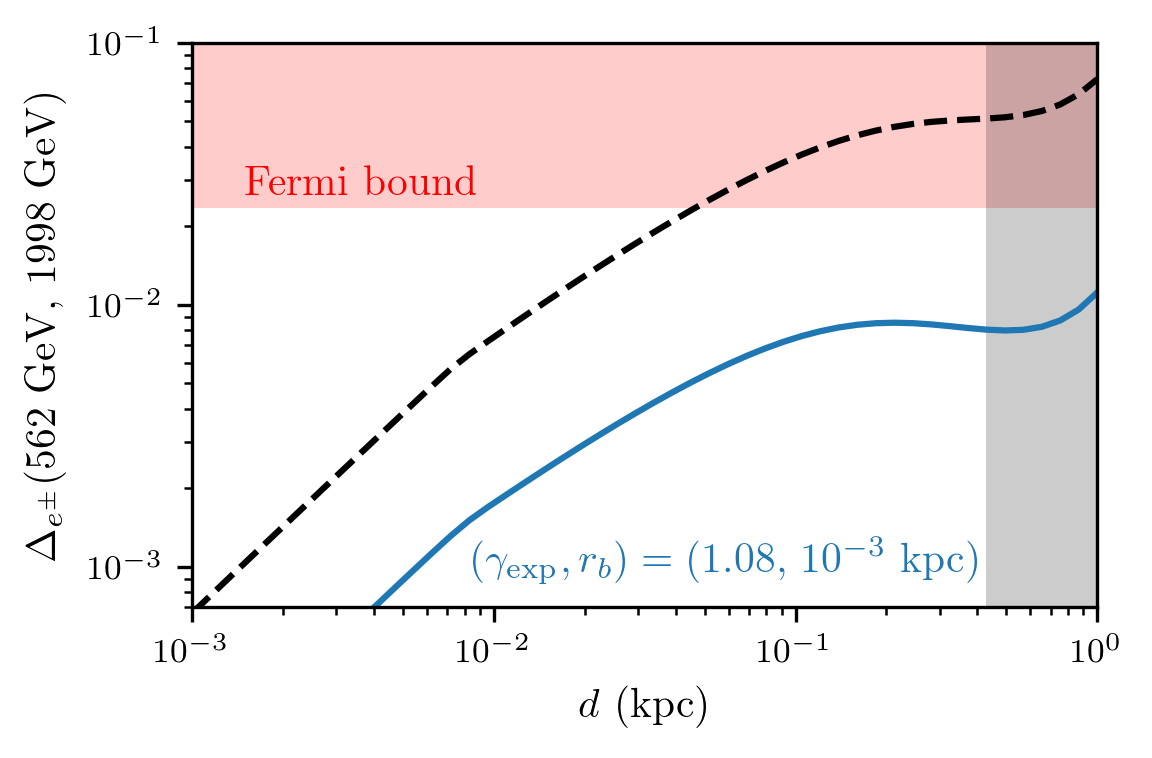

In [44]:
plt.figure(figsize=(4, 2.7))
plt.xlim(dist[[0, -1]])
plt.ylim(7e-4, 1e-1)
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$\Delta_{e^\pm}(562~\mathrm{GeV},\, 1998~\mathrm{GeV})$")

plt.loglog(dist, aniso_int, '--k')
plt.plot(dist, anisos_exp[0], label="{}".format(r_s[0]))

plt.axhspan(aniso_fermi[-1], 1e-1, linestyle='-', color='r', alpha=0.2, linewidth=0)
plt.axvspan(dist[np.where(lw_pt > n_sigma)[0][0]], dist[-1],
            color='k', alpha=0.2, linewidth=0)
plt.text(1.5e-3, 2.6e-2, "Fermi bound", color="r", fontsize=10)
plt.text(8.5e-3, 9e-4,
         r"$(\gamma_{\mathrm{exp}}, r_b) = (1.08,\, 10^{%i}~\mathrm{kpc})$" %
         mantissa_exp(r_s[0])[1], color=colors[0], fontsize=10)

plt.tight_layout()
plt.savefig("figures/aniso_int_pt.pdf")

## $e^\pm$ spectra and density profiles

Compute clump normalizations and spectra

### Varying $r_s$

#### Differential flux

In [2]:
gamma_exp = 0.74
r_s = np.array([1e-3, 2e-2, 5e-1, 2e0])
dist = 10e-1

# mx = 1700.0

In [3]:
rho_s_exp = rho_s_dampe(dist, r_s, gamma_exp, "exp")

In [4]:
# Determine whether the clump is excluded by line width
lw_excess = []

for r, rho in zip(r_s, rho_s_exp):
    lw_excess.append(line_width_constraint(dist, r, rho, gamma_exp, "exp"))
    
lw_excess = np.array(lw_excess)

In [5]:
e_epm = np.linspace(500, 2000, 500)

phi_e_exp = []
for r, rho in zip(r_s, rho_s_exp):
    phi_e_exp.append(
        phi_e(e_epm, dist, r, rho, gamma_exp, "exp"))
phi_e_exp = np.array(phi_e_exp)

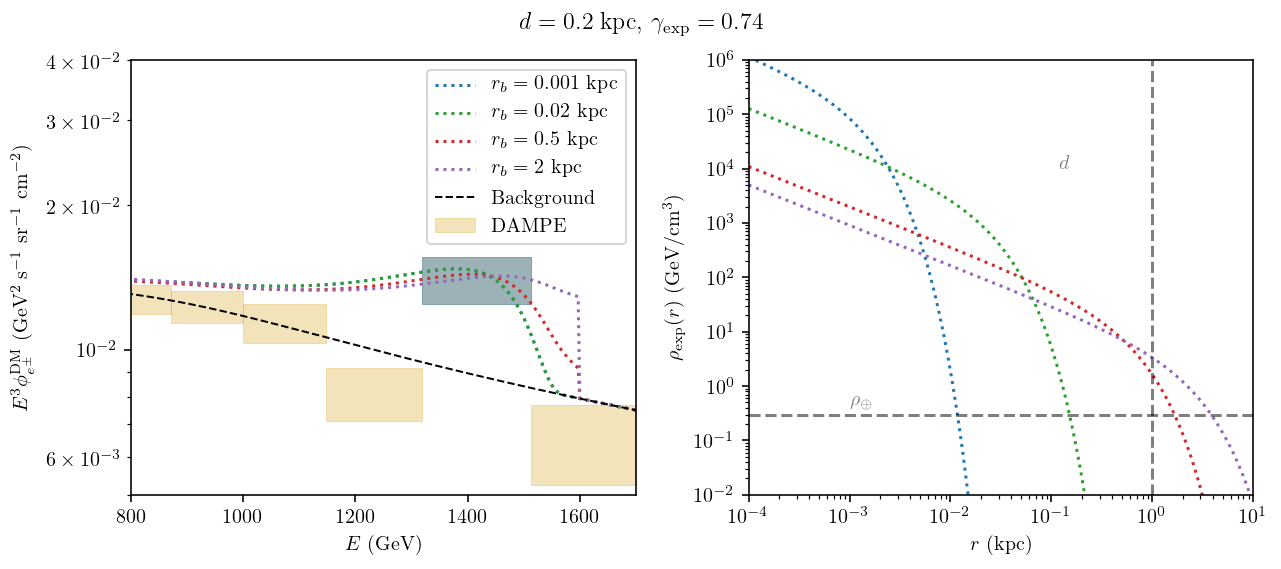

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

# e+/e- fluxes
ax = axs[0]
# DAMPE observations
power = 3
plot_obs(power, ax, True)
# DM
for phi, r, lw_ex, c in zip(phi_e_exp, r_s, lw_excess, clump_cols):
    if lw_ex > 3.:
        linestyle = ":"
    else:
        linestyle = "-"

    if int(r) == r:
        label = r"$r_b = {}$ kpc".format(int(r))
    else:
        label = r"$r_b = {}$ kpc".format(r)
    
    # Factor of two since we want the e+- spectrum
    ax.plot(e_epm, e_epm**power * (2*phi + phi_e_bg_dampe(e_epm)),
            color=c, linestyle=linestyle, label=label)
    
# Background only
ax.plot(e_epm, e_epm**3 * phi_e_bg_dampe(e_epm), "--k",
        linewidth=1, label="Background")
# Formatting
ax.set_yscale('log')
ax.set_xlim(8e2, 1.7e3)
# ax.set_ylim(1e-12, 1e-10)  # power=0
# ax.set_ylim(2e-6, 4e-5)  # power=2
ax.set_ylim(5e-3, 4e-2)  # power=3
ax.legend()
ax.set_xlabel(r"$E$ (GeV)")
ax.set_ylabel(r"$E^3 \phi_{e^\pm}^{\rm DM}$ (GeV$^2$ s$^{-1}$ sr$^{-1}$ cm$^{-2}$)")

# Halo profiles
ax = axs[1]
rs = np.logspace(-4, 1, 500)
for r, rho, lw_ex, c in zip(r_s, rho_s_exp, lw_excess, clump_cols):
    if lw_ex > 3.:
        linestyle = ":"
    else:
        linestyle = "-"
    ax.loglog(rs, density_profile(rs, r, rho, gamma_exp, "exp"),
              color=c, linestyle=linestyle)
    
    rho_cl = density_profile(dist, r, rho, gamma_exp, "exp")

ax.axvline(dist, color="k", linestyle="--", alpha=0.5)
ax.text(1.2e-1, 1e4, r"$d$", alpha=0.5)
ax.axhline(rho_earth, color="k", linestyle="--", alpha=0.5)
ax.text(1e-3, 4e-1, r"$\rho_\oplus$", alpha=0.5)
ax.set_xlim(rs[[0, -1]])
ax.set_ylim(1e-2, 1e6)
ax.set_xlabel(r"$r$ (kpc)")
ax.set_ylabel(r"$\rho_{\rm exp}(r)$ (GeV/cm$^3$)")

fig.suptitle(r"$d = 0.2$ kpc, $\gamma_{\rm exp} = %.2f$" % gamma_exp)
fig.tight_layout()
fig.subplots_adjust(top=0.90)

# fig.savefig("figures/epm_spectra_clump_profiles_exp.pdf")

#### Integrated flux

In [9]:
from scipy.interpolate import UnivariateSpline

In [18]:
gamma_exp = 0.74
r_s = np.array([1e-3, 2e-2, 5e-1, 2e0])
dist = 10e-1

In [19]:
# Get density normalizations for each r_s value
rho_s_exp = rho_s_dampe(dist, r_s, gamma_exp, "exp")

In [20]:
# Determine whether the clump is excluded by line width
lw_excess = []

for r, rho in zip(r_s, rho_s_exp):
    lw_excess.append(line_width_constraint(dist, r, rho, gamma_exp, "exp"))
    
lw_excess = np.array(lw_excess)

In [21]:
lw_excess

array([5.75258438, 5.75115526, 5.35299418, 5.18346285])

In [22]:
# Compute differential clump flux in each bin
e_epm = np.linspace(500, 2000, 5000)

phi_e_exp = []
for r, rho in zip(r_s, rho_s_exp):
    phi_e_exp.append(
        phi_e(e_epm, dist, r, rho, gamma_exp, "exp"))
phi_e_exp = np.array(phi_e_exp)

In [23]:
# Compute integrated flux from clump in each bin
Phi_e_exp = []

phi_e_exp_interps = [UnivariateSpline(e_epm, phi_e_vals) for phi_e_vals in phi_e_exp]

for phi_e_interp in phi_e_exp_interps:
    Phi_e_exp.append([
        phi_e_interp.integral(e_low, e_high) for (e_low, e_high) in zip(e_lows_dampe, e_highs_dampe)
    ])
Phi_e_exp = np.array(Phi_e_exp)

# Compute integrated background flux in each bin
Phi_e_bg = np.array([
    quad(phi_e_bg_dampe, e_low, e_high, epsabs=1e-100)[0]
    for (e_low, e_high) in zip(e_lows_dampe, e_highs_dampe)
])

# Compute observed integrated flux and errors
Phi_e_dampe = np.array([
    (e_high - e_low) * phi_e_val
    for (e_low, e_high, phi_e_val) in zip(e_lows_dampe, e_highs_dampe, phis_dampe)
])
Phi_errs_dampe = np.array([
    (e_high - e_low) * phi_err
    for (e_low, e_high, phi_err) in zip(e_lows_dampe, e_highs_dampe, phi_errs_dampe)
])

Text(0,0.5,'$\\Phi_{e^\\pm}^{\\rm DM}$ (s$^{-1}$ sr$^{-1}$ cm$^{-2}$)')

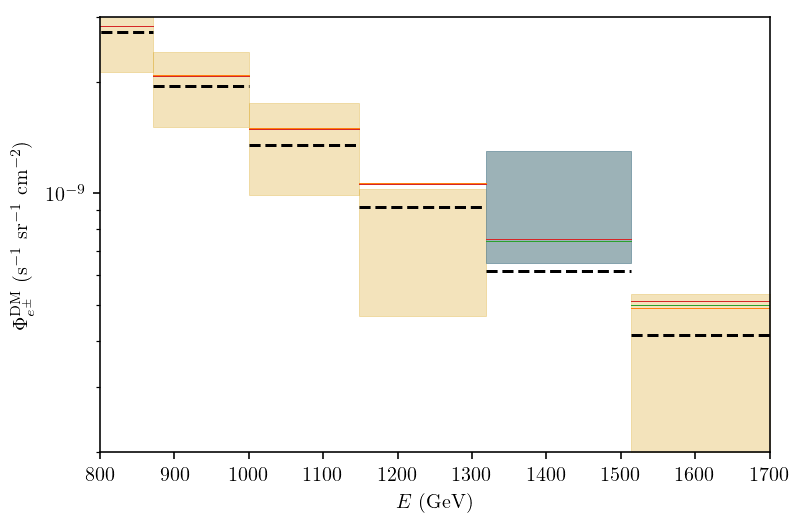

In [24]:
power = 0

# Plot integrated flux from clump
for (Phi_es, c) in zip(Phi_e_exp, colors):
    for (e_low, e_high, e, Phi_e, Phi_bg) in zip(e_lows_dampe, e_highs_dampe, es_dampe, Phi_es, Phi_e_bg):
        if Phi_e > 0:
            plt.plot([e_low, e_high], 2 * [e**power * (Phi_e + Phi_bg)], color=c, linewidth=0.5)

# Plot integrated background flux
for (e_low, e_high, e, Phi_e) in zip(e_lows_dampe, e_highs_dampe, es_dampe, Phi_e_bg):
    if Phi_e > 0:
        plt.plot([e_low, e_high], 2 * [e**power * Phi_e], "--k")

# Plot observations
n_sigma = 3
plot_obs_helper(e_lows_dampe, e_highs_dampe, es_dampe**power * Phi_e_dampe,
                es_dampe**power * n_sigma * Phi_errs_dampe, plt.gca(), label="DAMPE",
                alpha=0.3, lw=0.5, color="goldenrod")
excess_idxs = [29]

plot_obs_helper([e_low_excess], [e_high_excess],
                es_dampe[excess_idxs]**power * (e_high_excess - e_low_excess) * phis_dampe[excess_idxs],
                es_dampe[excess_idxs]**power * n_sigma * (e_high_excess - e_low_excess) * phi_errs_dampe[excess_idxs],
                plt.gca(), alpha=0.5, lw=0.5, color="steelblue")

plt.xlim(8e2, 1.7e3)
plt.ylim(2e-10, 3e-9)  # power = 0
# plt.ylim(4e-7, 3e-6)  # power = 1
plt.yscale("log")
plt.xlabel(r"$E$ (GeV)")
plt.ylabel(r"$\Phi_{e^\pm}^{\rm DM}$ (s$^{-1}$ sr$^{-1}$ cm$^{-2}$)")

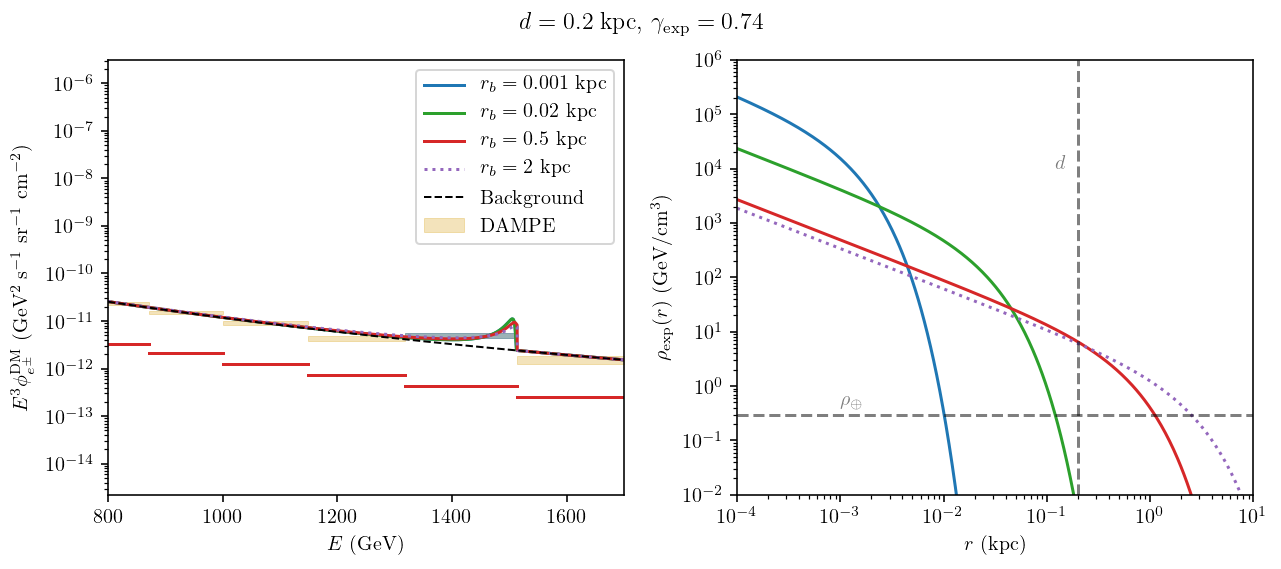

In [102]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

# e+/e- fluxes
ax = axs[0]
# DAMPE observations
# power = 3
power = 0
plot_obs(power, ax, True)
# DM
for phi, r, lw_ex, c in zip(phi_e_exp, r_s, lw_excess, clump_cols):
    if lw_ex > 3.:
        linestyle = ":"
    else:
        linestyle = "-"

    if int(r) == r:
        label = r"$r_b = {}$ kpc".format(int(r))
    else:
        label = r"$r_b = {}$ kpc".format(r)
    
    # Factor of two since we want the e+- spectrum
    ax.plot(e_epm, e_epm**power * (2*phi + phi_e_bg_dampe(e_epm)),
            color=c, linestyle=linestyle, label=label)
    
# DM, integrated
for (Phi_es, c) in zip(Phi_e_exp, colors):
    for (e_low, e_high, e, Phi_e, Phi_bg) in zip(e_lows_dampe, e_highs_dampe, es_dampe, Phi_es, Phi_e_bg):
        if Phi_e > 0:
            ax.plot([e_low, e_high], 2 * [e**power * (2*0 + Phi_bg) / e], color=c)
    
# Background only
ax.plot(e_epm, e_epm**power * phi_e_bg_dampe(e_epm), "--k",
        linewidth=1, label="Background")
# Formatting
ax.set_yscale('log')
ax.set_xlim(8e2, 1.7e3)
# ax.set_ylim(1e-12, 1e-10)  # power=0
# ax.set_ylim(2e-6, 4e-5)  # power=2
# ax.set_ylim(5e-3, 4e-2)  # power=3
ax.legend()
ax.set_xlabel(r"$E$ (GeV)")
ax.set_ylabel(r"$E^3 \phi_{e^\pm}^{\rm DM}$ (GeV$^2$ s$^{-1}$ sr$^{-1}$ cm$^{-2}$)")

# Halo profiles
ax = axs[1]
rs = np.logspace(-4, 1, 500)
for r, rho, lw_ex, c in zip(r_s, rho_s_exp, lw_excess, clump_cols):
    if lw_ex > 3.:
        linestyle = ":"
    else:
        linestyle = "-"
    ax.loglog(rs, density_profile(rs, r, rho, gamma_exp, "exp"),
              color=c, linestyle=linestyle)
    
    rho_cl = density_profile(dist, r, rho, gamma_exp, "exp")

ax.axvline(dist, color="k", linestyle="--", alpha=0.5)
ax.text(1.2e-1, 1e4, r"$d$", alpha=0.5)
ax.axhline(rho_earth, color="k", linestyle="--", alpha=0.5)
ax.text(1e-3, 4e-1, r"$\rho_\oplus$", alpha=0.5)
ax.set_xlim(rs[[0, -1]])
ax.set_ylim(1e-2, 1e6)
ax.set_xlabel(r"$r$ (kpc)")
ax.set_ylabel(r"$\rho_{\rm exp}(r)$ (GeV/cm$^3$)")

fig.suptitle(r"$d = 0.2$ kpc, $\gamma_{\rm exp} = %.2f$" % gamma_exp)
fig.tight_layout()
fig.subplots_adjust(top=0.90)

# fig.savefig("figures/epm_spectra_clump_profiles_exp.pdf")

### Varying $d$ (plots for paper)

#### Differential flux (plots for paper)

In [122]:
gamma_exp = 0.5

ds = {0: np.array([0.1, 0.5, 1.5]),
      1: np.array([0.1, 0.1, 0.1])}
rss = {0: np.array([0.01, 0.01, 0.01]),
       1: np.array([0.1, 1, 10])}

In [123]:
mxs = {}
for i in [0, 1]:
    mxs[i] = fit_mx(ds[i], rss[i], gamma_exp, "exp", "z", excl_idxs)

fit (d, rs) = (0.1, 0.01)
fit (d, rs) = (0.1, 0.01)
fit (d, rs) = (0.5, 0.01)
fit (d, rs) = (1.5, 0.01)
fit (d, rs) = (0.1, 0.1)
fit (d, rs) = (0.1, 0.1)
fit (d, rs) = (0.1, 1.0)
fit (d, rs) = (0.1, 10.0)


In [124]:
rhos = {}
for i in [0, 1]:
    rhos[i] = np.vectorize(rho_s_dampe)(ds[i], rss[i], gamma_exp, "exp", mxs[i])

In [125]:
e_epm = np.geomspace(758, 1738, 500)
phis = {0: [], 1: []}

for i in [0, 1]:
    for d, r, rho, mx in zip(ds[i], rss[i], rhos[i], mxs[i]):
        phis[i].append(phi_e(e_epm, d, r, rho, gamma_exp, "exp", mx))

In [126]:
phi_avgs = {0: [], 1: []}
e_lows = []
e_highs = []

for i in [0, 1]:
    for d, r, rho, mx in zip(ds[i], rss[i], rhos[i], mxs[i]):
        phi_avg = []
        for (e_low, e_high) in bins_dampe:
            if e_low >= e_epm[0] and e_high <= e_epm[-1]:
                e_lows.append(e_low)
                e_highs.append(e_high)
                args = (d, r, rho, gamma_exp, "exp", mx)
                Phi_dm = 2 * quad(phi_e, e_low, e_high, args, epsabs=0, epsrel=1e-5)[0]
                Phi_bg = Phi_e_bg(e_low, e_high)
                phi_avg.append((Phi_dm + Phi_bg) / (e_high - e_low))

        phi_avgs[i].append(phi_avg)

In [135]:
# Determine whether the clump is excluded by line width
lw_constrs = {0: [], 1: []}
lw_constrs_alt = {0: [], 1: []}

for i in [0, 1]:
    for d, r, rho, mx in zip(ds[i], rss[i], rhos[i], mxs[i]):
        lw_constrs[i].append(line_width_constraint(d, r, rho, gamma_exp, "exp", mx))
        lw_constrs_alt[i].append(line_width_constraint(d, r, rho, gamma_exp, "exp", mx,
                                                       excluded_idxs=[i_excess - 1]))
    lw_constrs[i] = np.array(lw_constrs[i])
    lw_constrs_alt[i] = np.array(lw_constrs_alt[i])

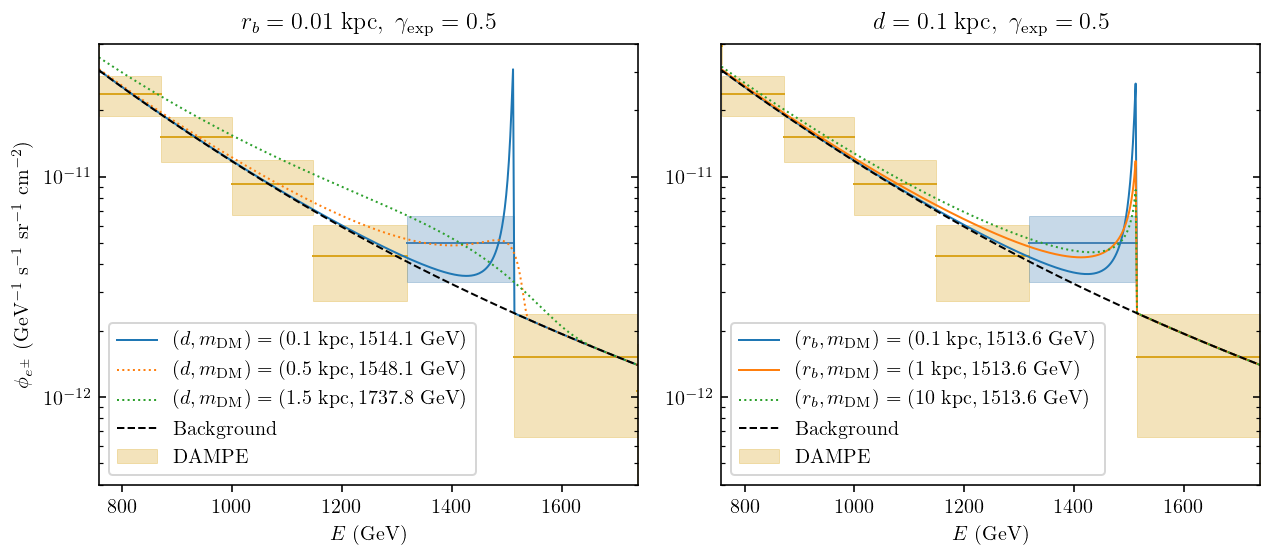

In [157]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

power = 0

for i in [0, 1]:
    ax = axes[i]
    
    # DAMPE observations
    plot_obs(power, ax, True, n_sigma=3, alpha=0.3)

    # DM
    for phi, phi_avg, d, r, lw_ex, mx, c in zip(phis[i], phi_avgs[i], ds[i], rss[i],
                                                lw_constrs[i], mxs[i], colors):
        if lw_ex > 3.:
            linestyle = ":"
        else:
            linestyle = "-"

        if i == 0:
            label = (r"$(d, m_{\mathrm{DM}}) = " +
                     "({}".format(sci_fmt(d)) + "~\mathrm{kpc}, " +
                     "{:.1f}".format(mx) + "~\mathrm{GeV})$")
        else:
            label = (r"$(r_b, m_{\mathrm{DM}}) = " +
                     "({}".format(sci_fmt(r)) + "~\mathrm{kpc}, " +
                     "{:.1f}".format(mx) + "~\mathrm{GeV})$")

        # Factor of two since we want the e+- spectrum
        ax.plot(e_epm, e_epm**power * (2*phi + phi_e_bg_dampe(e_epm)),
                color=c, linestyle=linestyle, label=label, linewidth=1)
        
        # Bin-averaged spectrum
#         for (e_low, e_high, phi_avg) in zip(e_lows, e_highs, phi_avg):
#             ax.plot([e_low, e_high], [phi_avg, phi_avg], color=c, linewidth=1)
    
    # Background only
    ax.plot(e_epm, e_epm**power * phi_e_bg_dampe(e_epm), "--k",
            linewidth=1, label="Background")

    # Formatting
    ax.set_yscale('log')
    ax.set_xlim(e_epm[[0, -1]])
#     ax.set_ylim(2e-3, 8e-1)  # power=3
    ax.set_ylim(4e-13, 4e-11)
    ax.legend()
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis="y", direction="in", right=True, which="both")
    ax.set_xlabel(r"$E$ (GeV)")
    if i == 0:
        ax.set_ylabel(
            r"$\phi_{e^\pm}$ (GeV$^{-1}$ s$^{-1}$ sr$^{-1}$ cm$^{-2}$)")

axes[0].set_title(r"$r_b = %.2f~\mathrm{kpc},\ \gamma_{\mathrm{exp}} = 0.5$" % rss[0][0])
axes[1].set_title(r"$d = %.1f~\mathrm{kpc},\ \gamma_{\mathrm{exp}} = 0.5$" % ds[1][0])

fig.tight_layout()

fig.savefig("figures/lw_constraint_n_sigma.pdf")

In [134]:
lw_constrs

{0: array([2.08122456, 3.37844084, 7.24212767]),
 1: array([2.11581041, 2.85342383, 3.7258535 ])}

In [129]:
os.system("say 'done'")

0

Alternative treatment using $\chi^2$ test statistic and Wilks' theorem

In [72]:
# Determine whether the clump is excluded by line width
lw_constrs = {0: [], 1: []}

for i in [0, 1]:
    for d, r, rho, mx in zip(ds[i], rss[i], rhos[i], mxs[i]):
        lw_constrs[i].append(line_width_constraint_chi2(d, r, rho, gamma_exp, "exp", mx))#,
#                                                         excluded_idxs=[i_excess - 1]))
    lw_constrs[i] = np.array(lw_constrs[i])

In [82]:
# chi2 value for very narrow spike is 27.53605287
d_0 = 0.001
r_s_0 = 0.001
rho_0 = rho_s_dampe(d_0, r_s_0, 0.5, "nfw")
chi2_0 = line_width_constraint_chi2(d_0, r_s_0, rho_0, 0.5, "exp")

In [80]:
for i in [0, 1]:
    print(lw_constrs[i] - chi2_0 > chi2(1).ppf(0.997))

[False False False  True  True]
[False False  True]


#### With clump profile

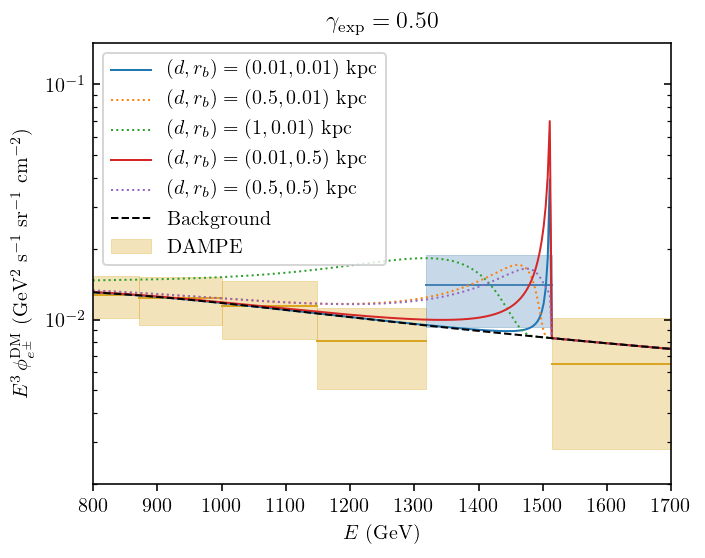

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

## e+/e- fluxes
# ax = axs[0]

# DAMPE observations
power = 3
# plot_obs(power, ax, True)
plot_obs(power, ax, True, n_sigma=3, alpha=0.3)
# plot_obs(power, ax, True, n_sigma=2, alpha=0.2)
# plot_obs(power, ax, True, n_sigma=1, alpha=0.2)
# plot_obs(power, ax, True, n_sigma=1, alpha=0.15)

# DM
for phi, d, r, lw_ex, c in zip(phi_e_exp, dist, r_s, lw_excess, colors):
    if lw_ex > 3.:
        linestyle = ":"
    else:
        linestyle = "-"

    label = r"$(d, r_b) = ({}, {})$ kpc".format(sci_fmt(d), sci_fmt(r))

    # Factor of two since we want the e+- spectrum
    ax.plot(e_epm, e_epm**power * (2*phi + phi_e_bg_dampe(e_epm)),
            color=c, linestyle=linestyle, label=label, linewidth=1)
    
# Background only
ax.plot(e_epm, e_epm**3 * phi_e_bg_dampe(e_epm), "--k",
        linewidth=1, label="Background")

# Formatting
ax.set_yscale('log')
ax.set_xlim(8e2, 1.7e3)
# ax.set_xscale('log')
# ax.set_ylim(1e-12, 1e-10)  # power=0
# ax.set_ylim(2e-6, 4e-5)  # power=2
ax.set_ylim(2e-3, 1.5e-1)  # power=3
ax.legend()
ax.yaxis.set_ticks_position('both')
ax.tick_params(axis="y", direction="in", right=True, which="both")
ax.set_xlabel(r"$E$ (GeV)")
ax.set_ylabel(r"$E^3\, \phi_{e^\pm}^{\rm DM}$ (GeV$^2$ s$^{-1}$ sr$^{-1}$ cm$^{-2}$)")

# ## Halo profiles
# ax = axs[1]
# rs = np.logspace(-4, 0, 500)
# for d, r, rho, lw_ex, c in zip(dist, r_s, rho_s_exp, lw_excess, colors):
#     if lw_ex > 3.:
#         linestyle = ":"
#     else:
#         linestyle = "-"
#     ax.loglog(rs, density_profile(rs - d, r, rho, gamma_exp, "nfw"),
#               color=c, linestyle=linestyle, linewidth=1)

# # ax.axvline(dist, color="k", linestyle="--", alpha=0.5)
# # ax.text(1.2e-1, 1e4, r"$d$", alpha=0.5)
# # ax.axhline(rho_earth, color="k", linestyle="--", alpha=0.5)
# # ax.text(1e-3, 4e-1, r"$\rho_\oplus$", alpha=0.5)
# ax.set_xlim(rs[[0, -1]])
# ax.set_ylim(1e-10, 1e5)
# ax.set_xlabel(r"$r$ (kpc)")
# ax.set_ylabel(r"$\rho_{\rm exp}(r)$ (GeV/cm$^3$)")

# fig.suptitle(r"$\gamma_{\rm exp} = %.2f$" % gamma_exp)
# fig.subplots_adjust(top=0.90)
ax.set_title(r"$\gamma_{\rm exp} = %.2f$" % gamma_exp)
fig.tight_layout()

# fig.savefig("figures/epm_spectra_clump_profiles_exp.pdf")

## Julia dev

In [70]:
dist = np.logspace(-3, 0, 2)
r_s = np.logspace(-3, 1, 2)
dist_mg, r_s_mg = np.meshgrid(dist, r_s)

rho_s_mg = rho_s_dampe(dist_mg, r_s_mg, 0.5, "nfw")

for i in range(len(dist)):
    for j in range(len(r_s)):
        print("(d, r_s, rho) = ({}, {}, {})".format(dist_mg[i, j], r_s_mg[i, j], rho_s_mg[i, j]))

(d, r_s, rho) = (0.001, 0.001, 5260.29992632)
(d, r_s, rho) = (1.0, 0.001, 526619.417807)
(d, r_s, rho) = (0.001, 10.0, 0.709941259703)
(d, r_s, rho) = (1.0, 10.0, 1.38276109157)


In [74]:
rho_s_dampe(1.0, 0.001, 1.0, "nfw")

array(263275.84795557)

In [79]:
rho_s_dampe(2.0, 0.001, 0.5, "nfw")

array(9502619.45785248)

In [65]:
rho_s_dampe(0.01, 0.01, 0.5, "nfw")

array(529.45989136)

In [66]:
line_width_constraint(0.01, 0.01, 529.45989136, 0.5, "nfw")

array(1.89539882)

In [17]:
from background_models import Phi_e_bg, phi_e_bg_dampe
Phi_e_bg(e_low_excess, e_high_excess)
phi_e_bg_dampe(100.)

1.619999998287378e-08

In [63]:
e_low, e_high = e_lows_dampe[0], e_highs_dampe[0]
Phi_bg_val = quad(phi_e_bg_dampe, e_low, e_high, epsabs=1e-100)[0]

In [64]:
quad(phi_e_bg_dampe, e_low, e_high)

(3.7889268970361415e-06, 4.206553879711074e-20)

In [60]:
e_low, e_high, (e_high - e_low) * phis_dampe[0], ((e_high - e_low) * phi_errs_dampe[0]), Phi_bg_val

(24.0, 27.5, 4.06e-06, 1.0499999999999999e-07, 3.7889268970361415e-06)

In [61]:
phi_e_bg_dampe(24.0), phi_e_bg_dampe(e_high)

(1.3324848430671078e-06, 8.749374188656224e-07)

In [57]:
(Phi_bg_val - (e_high - e_low) * phis_dampe[0]) / ((e_high - e_low) * phi_errs_dampe[0])

-2.581648599655796

In [25]:
Phi_excess - quad(phi_e_bg_dampe, e_low_excess, e_high_excess)[0]

3.56408522298898e-10

In [23]:
phi_e_bg_dampe(es)

array([2.55005770e-11, 1.07369095e-11, 5.05937661e-12, 2.65843111e-12,
       1.52577184e-12])

In [34]:
phi_e(1000., 0.01, 0.01, 1.0, 0.5, "nfw")

array(9.91204784e-21)

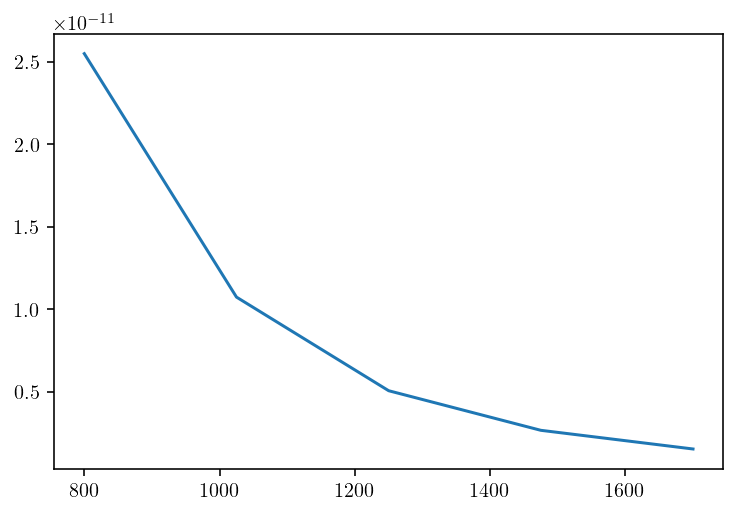

In [19]:
es = np.linspace(800, 1700, 5)
plt.plot(es, phi_e_bg_dampe(es))

In [35]:
es = np.linspace(800, 1700, 100)
fluxes = phi_e(es, 0.01, 0.01, 1, 0.5, "nfw")

In [6]:
for e, f in zip(es, fluxes):
    print(e, f)

(800.0, 7.709826937267687e-21)
(1025.0, 1.0403637744262643e-20)
(1250.0, 2.12782414293732e-20)
(1475.0, 3.1911179192825495e-19)
(1700.0, 0.0)


(5e-21, 1e-17)

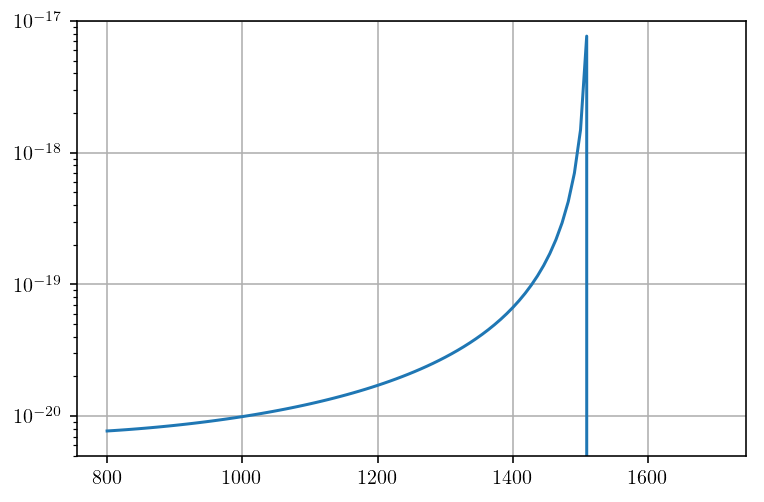

In [36]:
plt.semilogy(es, fluxes)
plt.grid()
plt.ylim(5e-21, 1e-17)

## $\gamma$-ray spectra

Fermi broadband flux sensitivity: max flux of a power law source at the detection threshold for any power law. From [here](http://www.slac.stanford.edu/exp/glast/groups/canda/lat_Performance.htm).

### Figure for section 4

In [140]:
gamma_exp = 0.74
r_s = np.array([1e-3, 2e-2, 5e-1, 2e0])
dist = 2e-1

th_maxes = np.array([fermi_psf, 1 * np.pi / 180])

In [141]:
rho_s_exp = rho_s_dampe(dist, r_s, gamma_exp, "exp")

In [142]:
# Determine whether the clump is excluded by line width
lw_excess = []

for r, rho in zip(r_s, rho_s_exp):
    lw_excess.append(line_width_constraint(dist, r, rho, gamma_exp, "exp"))
    
lw_excess = np.array(lw_excess)

In [143]:
e_g = np.linspace(30, 2000, 500)

phi_g_exp = {th: [] for th in th_maxes}
for th in th_maxes:
    for r, rho in zip(r_s, rho_s_exp):
        phi_g_exp[th].append(
            phi_g(e_g, dist, r, rho, gamma_exp, "exp", th_max=th))
    phi_g_exp[th] = np.array(phi_g_exp[th])

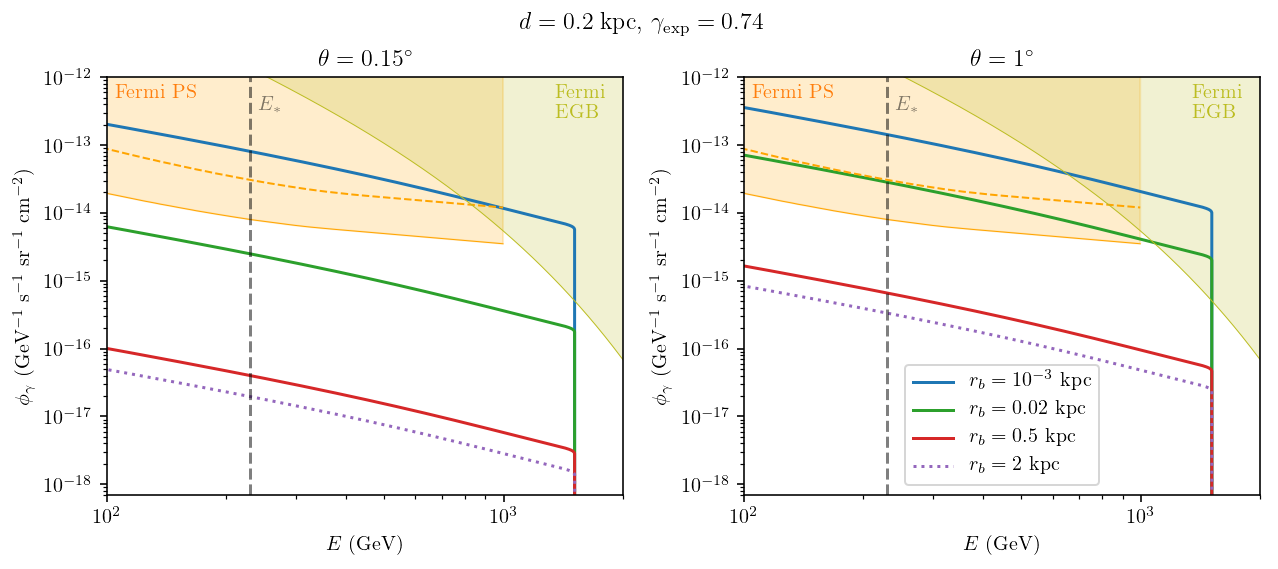

In [156]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
power = 0

for th, ax in zip(th_maxes, axs):
    # DM
    for phi, r, lw_ex, c in zip(phi_g_exp[th], r_s, lw_excess, clump_cols):
        if lw_ex > 3.:
            linestyle = ":"
        else:
            linestyle = "-"
        if int(r) == r:
            label = r"$r_b = {}$ kpc".format(int(r))
        else:
            label = r"$r_b = {}$ kpc".format(sci_fmt(r))
        ax.plot(e_g, e_g**power * phi,
                color=c, linestyle=linestyle, label=label)
    
    # Point source sensitivities
    ax.fill_between(e_g, e_g**power * fermi_pt_src_sens_120_45(e_g), np.ones_like(e_g),
                    color="orange", alpha=0.2, linewidth=1)
    ax.plot(e_g, e_g**power * fermi_pt_src_sens_120_45(e_g), "orange", linewidth=0.5)
    ax.plot(e_g, e_g**power * fermi_pt_src_sens_0_0(e_g), "--", color="orange", linewidth=1)
    # EGB flux
    ax.fill_between(e_g, e_g**power * phi_g_egb_fermi(e_g), np.ones_like(e_g),
                    color=colors[8], alpha=0.2, linewidth=0)
    ax.plot(e_g, e_g**power * phi_g_egb_fermi(e_g), colors[8], linewidth=0.5)
    
    # Formatting
    ax.axvline(230, color='k', linestyle='--', alpha=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(100, 2e3)
    ax.set_ylim(7e-19, 1e-12)
    ax.set_xlabel(r"$E$ (GeV)")
    ax.set_ylabel(r"$\phi_\gamma$ (GeV$^{-1}$ s$^{-1}$ sr$^{-1}$ cm$^{-2}$)")
    ax.text(1.05e2, 8e-13, "Fermi PS", color=colors[1], va="top")
    ax.text(1350, 8e-13, "Fermi\nEGB", color=colors[8], va="top")
    ax.text(240, 3e-13, r"$E_*$", alpha=0.5)

# axs[0].legend(loc="center left")
axs[1].legend(loc="lower center")
axs[0].set_title(r"$\theta = 0.15^\circ$")
axs[1].set_title(r"$\theta = 1^\circ$")

fig.suptitle(r"$d = 0.2$ kpc, $\gamma_{\rm exp} = %.2f$" % gamma_exp)
fig.tight_layout()
fig.subplots_adjust(top=0.87)

fig.savefig("figures/gamma_spectra_constraints_exp.pdf")

In [15]:
os.system("say 'done'")

0

#### Checking galactic background

In [10]:
e_fgdil, flux_fgdil = np.loadtxt("data/fermi/galactic_diffuse_intermediate_latitudes.csv").T
e_fgdil /= 1e3
flux_fgdil /= 1e3
flux_fgdil /= e_fgdil**2

In [16]:
1e-3/1e6**2 * 1e3

1e-12

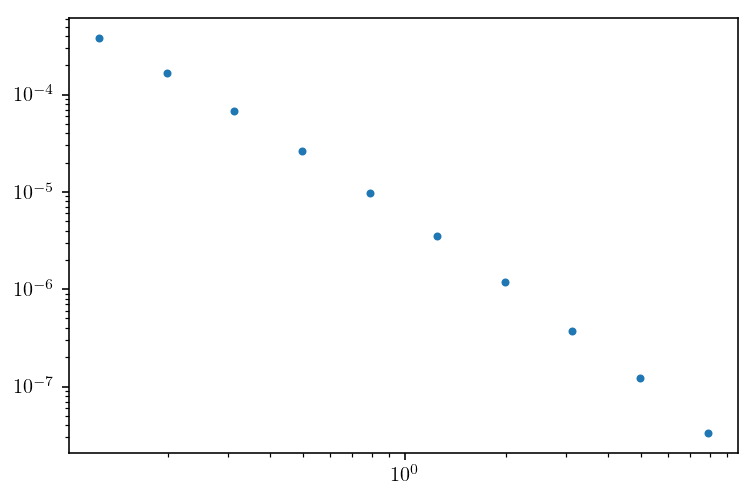

In [12]:
plt.loglog(e_fgdil, e_fgdil**power * flux_fgdil, '.')

### GC flux from DM

Flux from DM annihilating in the GC. This is quite subdominant to the flux from the clump.

In [3]:
rho_s_mw = 0.184
r_s_mw = 24.42
gamma_mw = 1.

phi_g(1.5e3, 8.5, r_s_mw, rho_s_mw, gamma_mw, "nfw", th_max=fermi_psf)

array(3.86814929e-18)

## $p_{N-\mathrm{body}}$

In [2]:
def load_sigmas(gamma_exp, halo="exp"):
    pr_base_path = "../DAMPE+DM clumps/data/likelihoods/"

    # Load likelihoods
    dist, r_s, pr = np.genfromtxt(
        pr_base_path + "{}/sigmas_exp_gamma_{}.csv".format(halo, gamma_exp),
        delimiter=',').T

    dist = dist.reshape(len(np.unique(dist)), -1).T
    r_s = r_s.reshape(dist.shape).T
    pr = pr.reshape(dist.shape).T
    
    return dist, r_s, pr

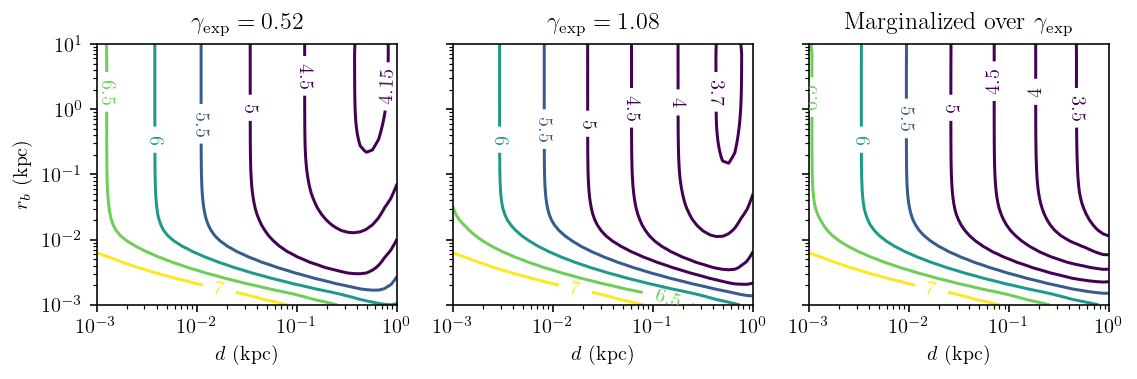

In [33]:
gammas = [0.52, 1.08, "grid"]
levels = {0.52: [4.15] + list(np.arange(4.5, 7.5, 0.5)),
          1.08: [3.7] + list(np.arange(4, 7.5, 0.5)),
          "grid": np.arange(3.5, 7.5, 0.5)}

fig, axes = plt.subplots(1, len(gammas), sharex=True, sharey=True, figsize=(8, 2.75))

for i, (gamma, ax) in enumerate(zip(gammas, axes)):    
    # Formatting
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$d$ (kpc)")
    if i == 0:
        ax.set_ylabel(r"$r_b$ (kpc)")
    if i in range(len(gammas) - 1):
        ax.set_title(r"$\gamma_{\mathrm{exp}} = %.2f$" % gamma)
    if gamma == gammas[-1]:
        ax.set_title("Marginalized over $\gamma_{\mathrm{exp}}$")

    # Plotting
    dist, r_s, pr = load_sigmas(gamma)
    normal_contours(dist, r_s, pr, ax, levels=levels[gamma])

fig.tight_layout()
fig.savefig("figures/z_scores_marginalized.pdf")